In [14]:
import gymnasium as gym
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

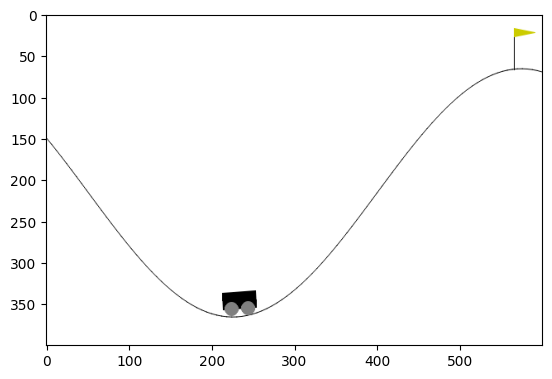

In [15]:
# Create the environment
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [16]:
# Action Space in MountainCar environment
print("Action Space: ", env.action_space)

Action Space:  Discrete(3)


In [17]:
# 1= push left, 2= no push, 3= push right

In [18]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [19]:
# Since in this  environment, position and velocity are continuous value. RL algorithm works only with discrete values.
# I need to split them into categories like bin.
# For better managing, I am gonna use 40 bins for velocity and 60 bins for position, I think this is enough to cover the whole range
# More bins need more time.

# Setting the number of bins for position and velocity
position_bins_value = 60
velocity_bins_value = 40


# In this environment, the observation space is 2D box, index 0 is X coordinate (position)  and index 1 is velocity (Y coordinate).
# .low is  NumPY array to stores the minimum value of the observation space and .high is the maximum value of the observation space.

# Define the range of position and velocity
position_min = env.observation_space.low[0]
position_max = env.observation_space.high[0]
velocity_min = env.observation_space.low[1] 
velocity_max = env.observation_space.high[1]


# For creating the bins, np.linspace is used to create evenly spaced values  between start and stop
# Create the bins for position and velocity
position_bins = np.linspace(position_min, position_max, position_bins_value)
velocity_bins = np.linspace(velocity_min, velocity_max, velocity_bins_value)
# Position ranges from -1.2 to 0.6 and I ued 60 bins
print(f'Each bin has a width  for position(X-coordinate) : {(position_max - position_min) / position_bins_value:.4f}')
print(f'Each bin has a width for velocity(Y-coordinate): {(velocity_max - velocity_min) / velocity_bins_value:.4f}')

print(f'Position Bins: {len(position_bins)}')
print(f'Velocity Bins: {len(velocity_bins)}')

# NOTE: I got the code structure from lecture notes

Each bin has a width  for position(X-coordinate) : 0.0300
Each bin has a width for velocity(Y-coordinate): 0.0035
Position Bins: 60
Velocity Bins: 40


In [20]:
# Define the Q table
Q_table = np.zeros((position_bins_value, velocity_bins_value, env.action_space.n))
Q_table.shape

(60, 40, 3)

**Q_table has 2400 states and 3 actions**

In [21]:
# I got this helper function from Lecture note 
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1]]) - Q[state[0], state[1], action])
    return Q

In [22]:
def get_state(observation):
    position = np.digitize(observation[0], bins=position_bins) - 1
    velocity = np.digitize(observation[1], bins=velocity_bins) - 1
    return position, velocity

In [23]:
total_episodes = 15000
max_steps = 200
learning_rate = 0.2
gamma = 0.99
epsilon = 0.9
max_epsilon = 0.9
min_epsilon = 0.0
decay_rate = 0.003

### Training loop

In [24]:
rewards = []
for episode in range(total_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0
    
    
    for step in range(max_steps):

        # exploration and exploitation
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(Q_table[state[0], state[1]])
        else:
            action = env.action_space.sample()
            
        new_state, reward, done, truncated, info = env.step(action)
        position = new_state[0]
        new_state = get_state(new_state)
        #reward += -0.01

        if done and position >= 0.5:
            reward = 150
            Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
            total_rewards += reward
            print(f'Episode {episode} done, steps needed {step}, rewards: {total_rewards:.3f}, epsilon: {epsilon:.3f}')
            break

        Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
        state = new_state
        total_rewards = total_rewards + reward

    rewards.append(total_rewards)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)      

Episode 1407 done, steps needed 171, rewards: -21.000, epsilon: 0.013
Episode 1479 done, steps needed 193, rewards: -43.000, epsilon: 0.011
Episode 1599 done, steps needed 171, rewards: -21.000, epsilon: 0.007
Episode 1608 done, steps needed 164, rewards: -14.000, epsilon: 0.007
Episode 1640 done, steps needed 171, rewards: -21.000, epsilon: 0.007
Episode 1644 done, steps needed 195, rewards: -45.000, epsilon: 0.007
Episode 1662 done, steps needed 186, rewards: -36.000, epsilon: 0.006
Episode 1673 done, steps needed 169, rewards: -19.000, epsilon: 0.006
Episode 1685 done, steps needed 168, rewards: -18.000, epsilon: 0.006
Episode 1699 done, steps needed 197, rewards: -47.000, epsilon: 0.006
Episode 1728 done, steps needed 177, rewards: -27.000, epsilon: 0.005
Episode 1763 done, steps needed 174, rewards: -24.000, epsilon: 0.005
Episode 1776 done, steps needed 198, rewards: -48.000, epsilon: 0.004
Episode 1777 done, steps needed 164, rewards: -14.000, epsilon: 0.004
Episode 1790 done, s

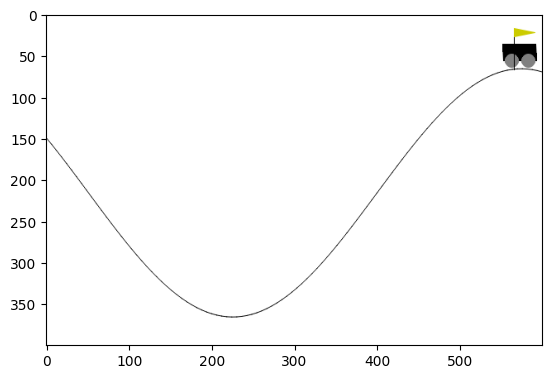

Episode: 2 done with total_rewards: -157.0


In [25]:
total_test_episodes = 2

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

for episode in range(total_test_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0


    for step in range(max_steps):
        
        
        action = np.argmax(Q_table[state[0], state[1]])
        observation, reward, done, truncated, info = env.step(action)
        observation = get_state(observation)
        total_rewards = total_rewards + reward

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break
        state = observation
env.close()